##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Networks

Much of the code in this notebook comes from [tensorflow's GitHub](https://github.com/tensorflow/docs/tree/master/site/en/tutorials).

## Learning Goals

- describe the types of layers that are distinctive for convolutional nets;
- utilize `tensorflow` to build CNNs;
- evaluate CNN models.

## What are CNNs?

From [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network):

- "CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks makes them prone to overfitting data. Typical ways of regularization include adding some form of magnitude measurement of weights to the loss function. However, CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns."
<br/>
<br/>
- "Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field."

### Convolving and Pooling

The two distinctive types of layer inside of a typical CNN (and there may be several of each in a single network) are **convolutional** and **pooling** layers. Let's look at each in turn.


#### Convolution
Convolutional nets employ [convolutions](https://en.wikipedia.org/wiki/Convolution), which are a certain kind of transformation. In the context of neural networks processing images, this can be thought of as sliding a filter (of weights) over the image matrix to produce a new matrix of values. (We'll detail the calculation below.) The relative smallness of the filter means both that there will be relatively few parameters to learn and that the values representing certain areas of the image will be affected only by the values of *nearby areas*. This helps the network in **feature detection**. Let's check out some visualizations [here](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/).

Utkarsh Sinha shows us some examples of different kinds of filters [here](http://aishack.in/tutorials/convolutions/).

Suppose we have a 3x3 image and a 2x2 filter. Then the calculation goes as follows:

$\begin{bmatrix}
a & b & c \\
d & e & g \\
h & j & k
\end{bmatrix} *
\begin{bmatrix}
f_1 & f_2 \\
f_3 & f_4
\end{bmatrix} =
\begin{bmatrix}
f_1a + f_2b + f_3d + f_4e & f_1b + f_2c + f_3e + f_4g \\
f_1d + f_2e + f_3h + f_4j & f_1e + f_2g + f_3j + f_4k
\end{bmatrix}$.

In words: Line up the filter with the image, multiply all the corresponding pairs and then add up those products. Repeat for all positions of the filter as allowed by [the stride and the padding](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/). The relative position of the filter to the image will tell you which entry in the resultant matrix you're filling in.

##### Exercise
Let's try an example of horizontal edge detection. One good filter for that might look like:

$\begin{bmatrix}
10 & 10 & 10 \\
0 & 0 & 0 \\
-10 & -10 & -10
\end{bmatrix}$

Suppose we apply this filter to (i.e. *convolve*) an image with a clear horizontal edge, such as this one:

$\begin{bmatrix}
200 & 200 & 200 & 200 & 200 \\
200 & 200 & 200 & 200 & 200 \\
200 & 200 & 200 & 200 & 200 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}$

<br/>
<br/>
<details><summary>
    Answer here
    </summary>
    <br/>
    $\begin{bmatrix}
    0 & 0 & 0 \\
    6000 & 6000 & 6000 \\
    6000 & 6000 & 6000 \\
    0 & 0 & 0
    \end{bmatrix}$
    Notice how the edge is now "highlighted"!
    </details>

[Here](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) is another good resource.

#### Pooling
What is pooling? The main goal in inserting a pooling layer is to reduce dimensionality, which helps to reduce both network computation and model overfitting. This is generally a matter of reducing a matrix or tensor of values to  some smaller size, and the most common way of doing this is by partitioning the large matrix into $n$ x $n$ blocks and then replacing each with the largest value in the block. Hence we speak of "MaxPooling".

Let's check out [this page](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/pooling_layer.html) for some visuals.

## From the TensorFlow Authors

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify MNIST digits. This simple network will achieve over 99% accuracy on the MNIST test set. Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras), creating and training our model will take just a few lines of code.

Note: CNNs train faster with a GPU. If you are running this notebook with Colab, you can enable the free GPU via * Edit -> Notebook settings -> Hardware accelerator -> GPU*.

### Import TensorFlow

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
import numpy as np

### Download and prepare the MNIST dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
test_images.shape

(10000, 28, 28)

In [5]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [10]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255, test_images / 255

In [11]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to color channels, MNIST has one (because the images are grayscale), whereas a color image has three (R,G,B). In this example, we will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST images. We do this by passing the argument `input_shape` to our first layer.



In [27]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

Let display the architecture of our model so far.

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trai

The number of parameters depends on the number of input and output channels of the layer in question. For more, see [this post](https://medium.com/@zhang_yang/number-of-parameters-in-dense-and-convolutional-neural-networks-34b54c2ec349) and [this post](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d).

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, we will feed the last output tensor from the convolutional base (of shape (3, 3, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. MNIST has 10 output classes, so we use a final Dense layer with 10 outputs and a softmax activation.

In [29]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

 Here's the complete architecture of our model.

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576) before going through two Dense layers.

### Compile and train the model

In [31]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [32]:
train_images.shape

(60000, 28, 28, 1)

In [33]:
model.fit(train_images, train_labels, epochs=10, batch_size=1000,
         validation_split=.25)

Epoch 1/10
45/45 [==============================] - 4s 89ms/step - loss: 0.9687 - accuracy: 0.7201 - val_loss: 0.3096 - val_accuracy: 0.9061
Epoch 2/10
45/45 [==============================] - 4s 86ms/step - loss: 0.2468 - accuracy: 0.9265 - val_loss: 0.1651 - val_accuracy: 0.9513
Epoch 3/10
45/45 [==============================] - 4s 87ms/step - loss: 0.1381 - accuracy: 0.9588 - val_loss: 0.1054 - val_accuracy: 0.9691
Epoch 4/10
45/45 [==============================] - 4s 87ms/step - loss: 0.0936 - accuracy: 0.9718 - val_loss: 0.0882 - val_accuracy: 0.9725
Epoch 5/10
45/45 [==============================] - 4s 92ms/step - loss: 0.0739 - accuracy: 0.9778 - val_loss: 0.0790 - val_accuracy: 0.9763
Epoch 6/10
45/45 [==============================] - 4s 95ms/step - loss: 0.0639 - accuracy: 0.9803 - val_loss: 0.0797 - val_accuracy: 0.9746
Epoch 7/10
45/45 [==============================] - 4s 91ms/step - loss: 0.0552 - accuracy: 0.9837 - val_loss: 0.0755 - val_accuracy: 0.9765
Epoch 8/10
45

### Evaluate the model

In [35]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.0363 - accuracy: 0.9878


In [36]:
test_acc

0.9878000617027283

As you can see, our simple CNN has achieved a really high test accuracy. Not bad for a few lines of code!

## Checking a Particular Image

In [40]:
test_images[0].reshape(1, 28, 28, 1).shape

(1, 28, 28, 1)

In [41]:
model.predict(test_images[0].reshape(1, 28, 28, 1))

1/1 [==============================] - 0s 84ms/step


array([[1.0536230e-08, 2.3610379e-08, 4.0033788e-06, 2.4787887e-05,
        5.9082170e-11, 8.9178961e-08, 1.7995488e-15, 9.9997020e-01,
        8.5153530e-08, 8.2470706e-07]], dtype=float32)

In [42]:
# Remember how we can get a prediction number from this?
np.argmax(model.predict(test_images[0].reshape(1, 28, 28, 1)))

1/1 [==============================] - 0s 20ms/step


7

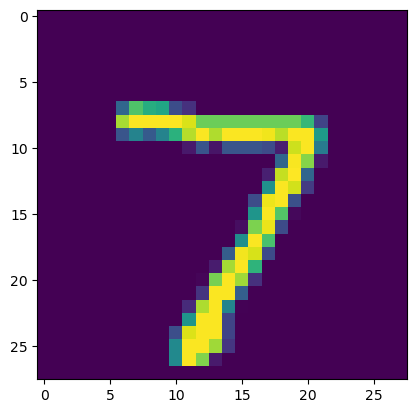

In [43]:
plt.imshow(test_images[0].reshape(28, 28));

In [44]:
np.argmax(model.predict(test_images[100].reshape(1, 28, 28, 1)))

1/1 [==============================] - 0s 19ms/step


6

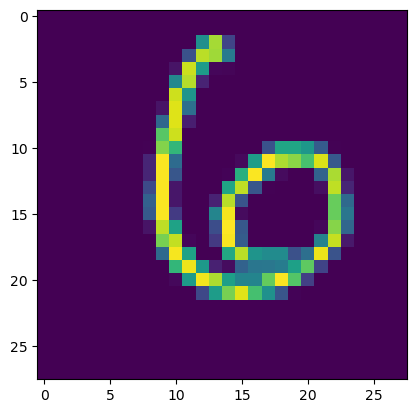

In [45]:
plt.imshow(test_images[100].reshape(28, 28));